In [367]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import numpy as NP

In [368]:
custom_colours = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
SNS.set_theme(style="whitegrid",palette=custom_colours)

In [369]:
raw_data = PD.read_csv("50_Startups.csv", sep=";")
data = raw_data.copy()

In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   R&D             50 non-null     float64
 1   Administration  50 non-null     float64
 2   Marketing       50 non-null     float64
 3   villes          50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.8+ KB


In [371]:
data.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


Paris         17
Strasbourg    17
Lyon          16
Name: villes, dtype: int64


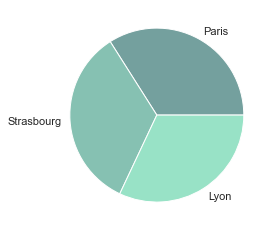

In [372]:
print(data["villes"].value_counts())
PLT.pie(data["villes"].value_counts(),labels=data["villes"].unique())
PLT.show()

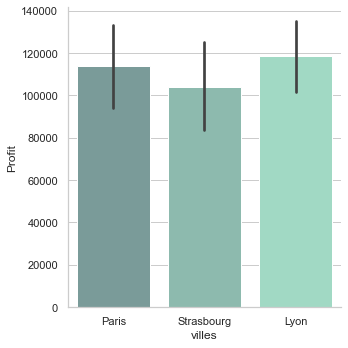

In [373]:
SNS.catplot(data=data,kind="bar",x="villes",y="Profit")

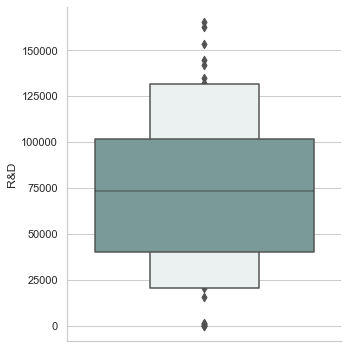

In [374]:
SNS.catplot(kind="boxen",data=data,y="R&D")

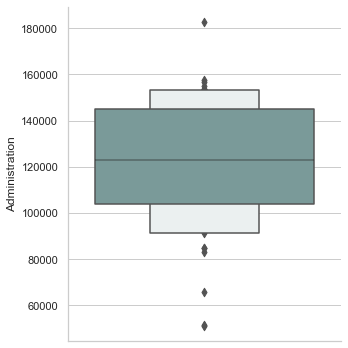

In [375]:
SNS.catplot(kind="boxen",data=data,y="Administration")

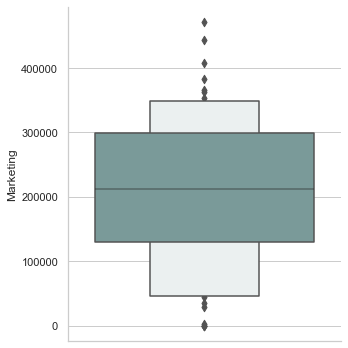

In [376]:
SNS.catplot(kind="boxen",data=data,y="Marketing")

In [377]:
# SNS.lineplot(data=data,palette="flare", linewidth=2.5)

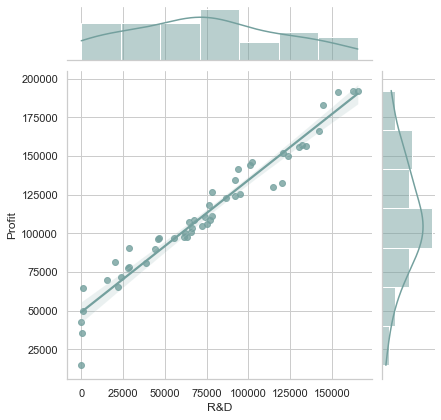

In [435]:
SNS.jointplot(x="R&D",y="Profit",kind="reg",data=data)

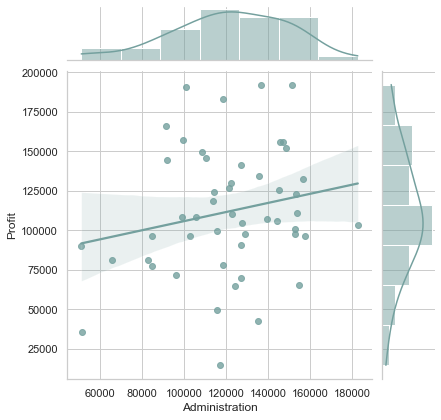

In [379]:
SNS.jointplot(x="Administration",y="Profit",kind="reg",data=data)

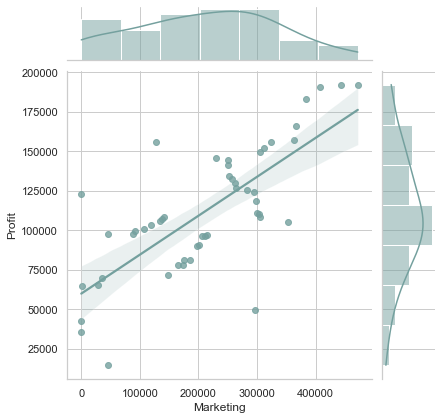

In [380]:
SNS.jointplot(x="Marketing",y="Profit",kind="reg",data=data)

In [381]:
data["Budget"] = data["R&D"]+data["Administration"]+data["Marketing"]
data.head()

,R&D,Administration,Marketing,villes,Profit,Budget
0,165349.20,136897.80,471784.10,Paris,192261.83,774031.10
1,162597.70,151377.59,443898.53,Strasbourg,191792.06,757873.82
2,153441.51,101145.55,407934.54,Lyon,191050.39,662521.60
3,144372.41,118671.85,383199.62,Paris,182901.99,646243.88
4,142107.34,91391.77,366168.42,Lyon,166187.94,599667.53


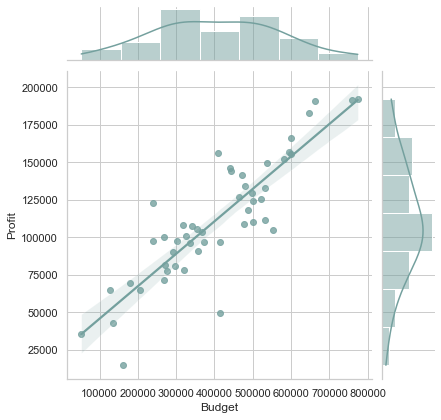

In [382]:
SNS.jointplot(x="Budget",y="Profit",kind="reg",data=data)

In [383]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score, max_error, mean_squared_error

In [384]:
LR = LinearRegression()
X = data.loc[:,data.columns != 'Profit'].copy()
X.drop("villes",axis=1,inplace=True)
y = data['Profit'].copy()

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=666)
LR.fit(X_train,y_train)

LinearRegression()

In [386]:
predictions = LR.predict(X_test)
res_df = PD.DataFrame(dict(R_et_D=X_test["R&D"],Administration=X_test['Administration'],Marketing=X_test['Marketing'], Budget=X_test['Budget'],y_true=y_test,y_pred=predictions))
print(f"Explained Variance Score \t= {explained_variance_score(y_test,predictions)}")
print(f"Max Error \t\t\t\t= {max_error(y_test,predictions)}")
print("Coefficients: \n", LR.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, predictions))
# res_df

Explained Variance Score 	= 0.928929087837613
Max Error 				= 41542.128000000004
Coefficients: 
 [ 3.63333911e+12  3.63333911e+12  3.63333911e+12 -3.63333911e+12]
Mean squared error: 218973616.89
Coefficient of determination: 0.93


Text(0, 0.5, 'y_pred AND y_true')

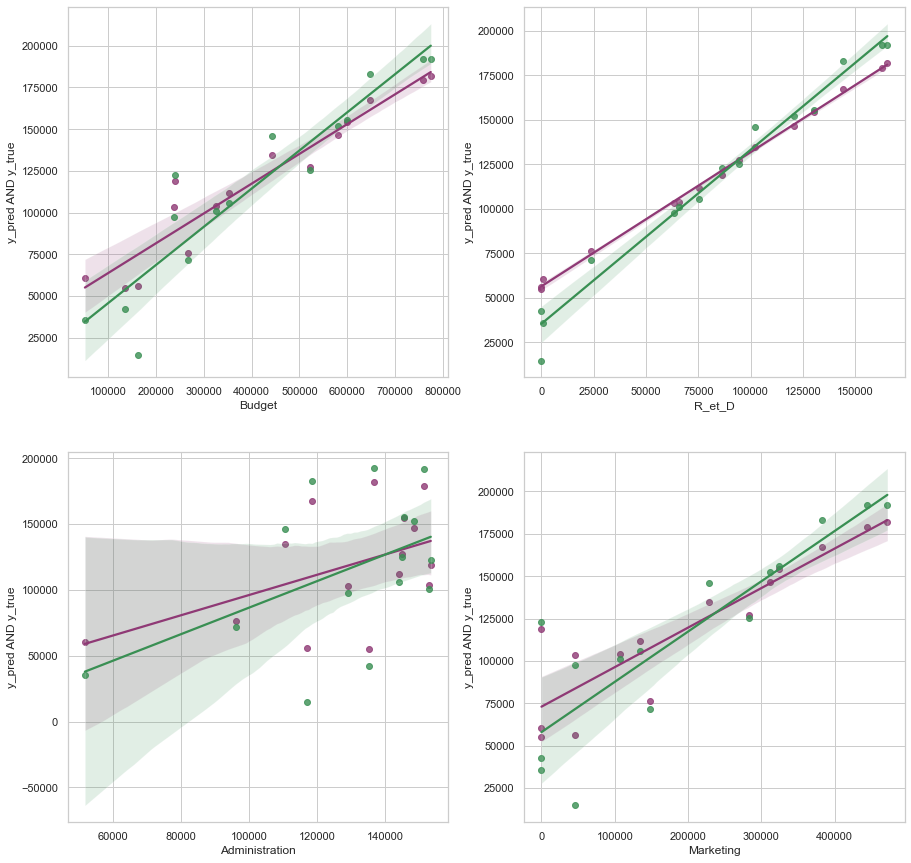

In [430]:
fig, ax = PLT.subplots(2,2,figsize=(15,15))
SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[0,0], color="#8F3975")
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[0,0], color="#398F53")
ax[0,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0,1], color="#8F3975")
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0,1], color="#398F53")
ax[0,1].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Administration",y="y_pred",data=res_df, ax=ax[1,0], color="#8F3975")
SNS.regplot(x="Administration",y="y_true",data=res_df, ax=ax[1,0], color="#398F53")
ax[1,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Marketing",y="y_pred",data=res_df, ax=ax[1,1], color="#8F3975")
SNS.regplot(x="Marketing",y="y_true",data=res_df, ax=ax[1,1], color="#398F53") 
ax[1,1].set_ylabel("y_pred AND y_true")

In [387]:
LR_Budget = LinearRegression()
X_budget = PD.DataFrame(data["Budget"].copy())
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_budget,y,test_size=.3,random_state=666)
LR_Budget.fit(Xb_train,yb_train)

LinearRegression()

In [436]:
B_predictions = LR_Budget.predict(Xb_test)
print(f"Explained Variance Score \t= {explained_variance_score(yb_test, B_predictions)}")
print(f"Max Error \t\t\t\t= {max_error(yb_test, B_predictions)}")
print("Coefficients: \n", LR_Budget.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(yb_test, B_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(yb_test, B_predictions))

Explained Variance Score 	= 0.8554769457666643
Max Error 				= 47035.563801990196
Coefficients: 
 [0.19960416]
Mean squared error: 459653649.18
Coefficient of determination: 0.85
